In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## bd_net


In [14]:
clean_data_fl = '/content/gdrive/MyDrive/Lab3/valid.h5'
poisoned_data_fl = '/content/gdrive/MyDrive/Lab3/bd_valid.h5'
model_fl = '/content/gdrive/MyDrive/Lab3/bd_net.h5'

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_fl)
    bd_x_test, bd_y_test = data_loader(poisoned_data_fl)

    bd_model = keras.models.load_model(model_fl)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


Here, we will see the model structure

In [15]:
model = keras.models.load_model(model_fl)

In [16]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Here, we will visualize the data to see what the clean data looks like.

In [17]:
x_data, y_data = data_loader(clean_data_fl)

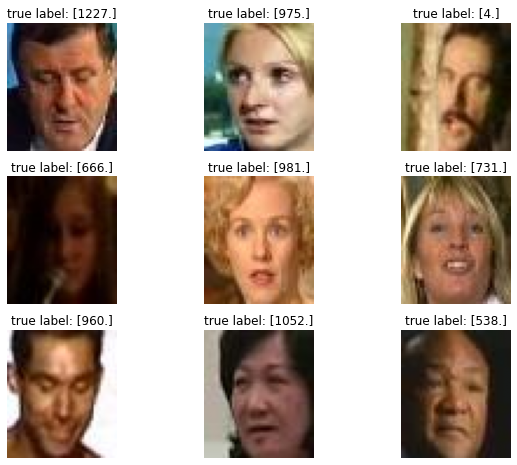

In [18]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Here, we will also visulize the poisoned data that has the sunglasses

In [19]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_fl)

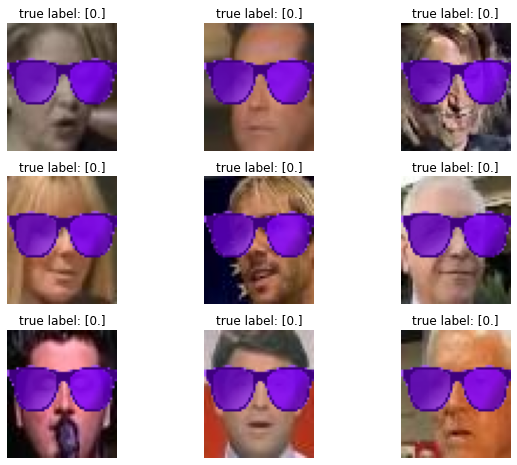

In [20]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [21]:
keras.backend.clear_session()

## Prune defense


In [22]:
cl_x_test, cl_y_test = data_loader(clean_data_fl)
bd_x_test, bd_y_test = data_loader(poisoned_data_fl)

In [23]:
clean_data_acc = 98.64899974019225 
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("clean accuracy: ",clean_accuracy)
  print("success rate: ",asr)
  print("pruned channel index: ",channel_index)
  keras.backend.clear_session()


  2%|▏         | 1/60 [00:17<16:47, 17.07s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  0


  3%|▎         | 2/60 [00:30<14:16, 14.77s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  26


  5%|▌         | 3/60 [00:47<14:59, 15.79s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  27


  7%|▋         | 4/60 [01:04<15:11, 16.27s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  30


  8%|▊         | 5/60 [01:20<14:51, 16.21s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  31


 10%|█         | 6/60 [01:33<13:38, 15.16s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  33


 12%|█▏        | 7/60 [01:49<13:35, 15.40s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  34


 13%|█▎        | 8/60 [02:05<13:29, 15.57s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  36


 15%|█▌        | 9/60 [02:16<12:00, 14.13s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  37


 17%|█▋        | 10/60 [02:27<10:58, 13.16s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  38


 18%|█▊        | 11/60 [02:43<11:26, 14.01s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  25


 20%|██        | 12/60 [02:54<10:36, 13.27s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  39


 22%|██▏       | 13/60 [03:11<11:10, 14.26s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  41


 23%|██▎       | 14/60 [03:23<10:30, 13.70s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  44


 25%|██▌       | 15/60 [03:40<10:58, 14.62s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  45


 27%|██▋       | 16/60 [03:52<10:09, 13.86s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  47


 28%|██▊       | 17/60 [04:08<10:29, 14.64s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  48


 30%|███       | 18/60 [04:21<09:43, 13.89s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  49


 32%|███▏      | 19/60 [04:37<10:01, 14.68s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  50


 33%|███▎      | 20/60 [04:54<10:09, 15.23s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  53


 35%|███▌      | 21/60 [05:15<11:00, 16.94s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  55


 37%|███▋      | 22/60 [05:27<09:49, 15.51s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  40


 38%|███▊      | 23/60 [05:39<08:53, 14.43s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  24


 40%|████      | 24/60 [05:55<09:02, 15.06s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  59


 42%|████▏     | 25/60 [06:12<09:01, 15.48s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  9


 43%|████▎     | 26/60 [06:25<08:21, 14.75s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  2


 45%|████▌     | 27/60 [06:44<08:53, 16.16s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  12


 47%|████▋     | 28/60 [06:55<07:41, 14.44s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  13


 48%|████▊     | 29/60 [07:05<06:50, 13.23s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  17


 50%|█████     | 30/60 [07:16<06:13, 12.46s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  14


 52%|█████▏    | 31/60 [07:26<05:42, 11.82s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  15


 53%|█████▎    | 32/60 [07:36<05:17, 11.35s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  23


 55%|█████▌    | 33/60 [07:47<04:58, 11.04s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  6


 57%|█████▋    | 34/60 [08:02<05:24, 12.47s/it]


clean accuracy:  98.64033948211657
success rate:  100.0
pruned channel index:  51


 58%|█████▊    | 35/60 [08:13<04:57, 11.91s/it]


clean accuracy:  98.64033948211657
success rate:  100.0
pruned channel index:  32


 60%|██████    | 36/60 [08:23<04:35, 11.49s/it]


clean accuracy:  98.63167922404088
success rate:  100.0
pruned channel index:  22


 62%|██████▏   | 37/60 [08:34<04:18, 11.25s/it]


clean accuracy:  98.65765999826795
success rate:  100.0
pruned channel index:  21


 63%|██████▎   | 38/60 [08:44<04:01, 10.97s/it]


clean accuracy:  98.64899974019225
success rate:  100.0
pruned channel index:  20


 65%|██████▌   | 39/60 [08:55<03:45, 10.72s/it]


clean accuracy:  98.6056984498138
success rate:  100.0
pruned channel index:  19


 67%|██████▋   | 40/60 [09:04<03:28, 10.43s/it]


clean accuracy:  98.57105741751104
success rate:  100.0
pruned channel index:  43


 68%|██████▊   | 41/60 [09:14<03:14, 10.26s/it]


clean accuracy:  98.53641638520828
success rate:  100.0
pruned channel index:  58


 70%|███████   | 42/60 [09:25<03:05, 10.31s/it]


clean accuracy:  98.19000606218066
success rate:  100.0
pruned channel index:  3


 72%|███████▏  | 43/60 [09:35<02:54, 10.24s/it]


clean accuracy:  97.65307006148784
success rate:  100.0
pruned channel index:  42


 73%|███████▎  | 44/60 [09:45<02:41, 10.12s/it]


clean accuracy:  97.50584567420108
success rate:  100.0
pruned channel index:  1
The accuracy drops at least 2%, saved the model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
 75%|███████▌  | 45/60 [09:54<02:30, 10.05s/it]


clean accuracy:  95.75647354291158
success rate:  100.0
pruned channel index:  29


 77%|███████▋  | 46/60 [10:04<02:19,  9.99s/it]


clean accuracy:  95.20221702606739
success rate:  99.9913397419243
pruned channel index:  16


 78%|███████▊  | 47/60 [10:14<02:09,  9.99s/it]


clean accuracy:  94.7172425738287
success rate:  99.9913397419243
pruned channel index:  56
The accuracy drops at least 4%, saved the model


 80%|████████  | 48/60 [10:25<02:00, 10.08s/it]


clean accuracy:  92.09318437689443
success rate:  99.9913397419243
pruned channel index:  46


 82%|████████▏ | 49/60 [10:35<01:51, 10.10s/it]


clean accuracy:  91.49562656967177
success rate:  99.9913397419243
pruned channel index:  5


 83%|████████▎ | 50/60 [10:45<01:42, 10.28s/it]


clean accuracy:  91.01931237550879
success rate:  99.98267948384861
pruned channel index:  8


 85%|████████▌ | 51/60 [10:56<01:33, 10.37s/it]


clean accuracy:  89.17467740538669
success rate:  80.73958603966398
pruned channel index:  11
The accuracy drops at least 10%, saved the model


 87%|████████▋ | 52/60 [11:06<01:23, 10.38s/it]


clean accuracy:  84.43751623798389
success rate:  77.015675067117
pruned channel index:  54


 88%|████████▊ | 53/60 [11:17<01:12, 10.35s/it]


clean accuracy:  76.48739932449988
success rate:  35.71490430414826
pruned channel index:  10


 90%|█████████ | 54/60 [11:27<01:01, 10.33s/it]


clean accuracy:  54.8627349095003
success rate:  6.954187234779596
pruned channel index:  28


 92%|█████████▏| 55/60 [11:38<00:52, 10.44s/it]


clean accuracy:  27.08928726076037
success rate:  0.4243526457088421
pruned channel index:  35


 93%|█████████▎| 56/60 [11:48<00:42, 10.50s/it]


clean accuracy:  13.87373343725643
success rate:  0.0
pruned channel index:  18


 95%|█████████▌| 57/60 [11:59<00:31, 10.51s/it]


clean accuracy:  7.101411622066338
success rate:  0.0
pruned channel index:  4


 97%|█████████▋| 58/60 [12:09<00:20, 10.49s/it]


clean accuracy:  1.5501861955486274
success rate:  0.0
pruned channel index:  7


 98%|█████████▊| 59/60 [12:20<00:10, 10.56s/it]


clean accuracy:  0.7188014202823244
success rate:  0.0
pruned channel index:  52


100%|██████████| 60/60 [12:31<00:00, 12.52s/it]


clean accuracy:  0.0779423226812159
success rate:  0.0
pruned channel index:  57


The result is shown below. We can see that the defense is not too successful because it compromises the accuracy.

In [27]:
print("clean accuracy: ",clean_acc)
print("attack success rate: ",asrate)

clean accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

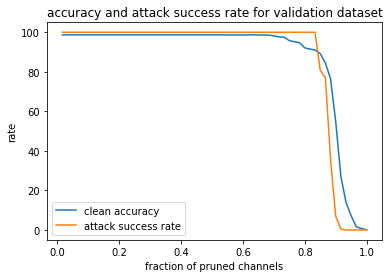

In [28]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [30]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("Attack success rate when the accuracy drops at least 30%: ",asrate[index[0]])

Attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combined models


In [31]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluation

In [34]:
test_data_filename = '/content/gdrive/MyDrive/Lab3/test.h5'
poisoned_test_data_filename = '/content/gdrive/MyDrive/Lab3/bd_test.h5'
test_model_X_2_filename = 'model_X=2.h5'
test_model_X_4_filename = 'model_X=4.h5'
test_model_X_10_filename = 'model_X=10.h5'

In [35]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [36]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [37]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [38]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

Evaluate on the test dataset

In [39]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data Classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data Classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

2% drops model, the clean test data Classification accuracy: 95.90023382696803
2% drops model, Attack Success Rate: 100.0
4% drops model, the clean test data Classification accuracy: 92.29150428682775
4% drops model, Attack Success Rate: 99.98441153546376
10% drops model, the clean test data Classification accuracy: 84.54403741231489
10% drops model, Attack Success Rate: 77.20966484801247


And summarize the repaired models

In [40]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


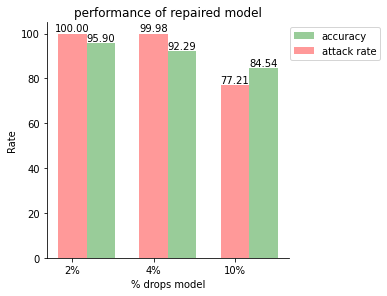

In [47]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='g', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

These are the goonets that combines two models which are original badNet and the repaired model

In [48]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [49]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


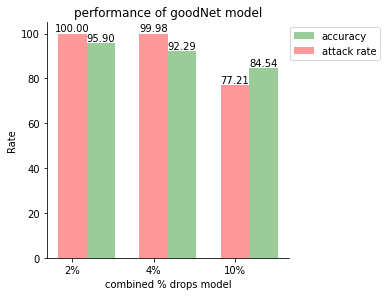

In [51]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='g', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()